# AAI500 Final Project
## Energy Prediction

### Group 3
### Name : Ashley Figueroa
### Name : Robert Shifrin
### Name : Carlo Casella
#### Date : 10 February 2026

This research project focused on developing data-driven predictive models for the energy consumption of appliances in a low-energy "passive" house located in Belgium. The study aimed to identify the most significant environmental and temporal predictors of energy use to improve building performance simulations and energy management.

Appliance Energy Prediction 

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters.
(https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction)




##### Energy Consumption Codes
Appliances: Aggregate electrical energy consumption of all appliances in the house (Wh).
Lights: Sub-metered electrical energy consumption of light fixtures (Wh).
Indoor Environment Codes (T = Temperature, RH = Humidity)

##### Zones or Rooms
• T1 / RH1: Kitchen area. 
• T2 / RH2: Living room area.
• T3 / RH3: Laundry room area.
• T4 / RH4: Office room.
• T5 / RH5: Bathroom.
• T7 / RH7: Ironing room.
• T8 / RH8: Teenager room 2.
• T9 / RH9: Parents room.


##### Weather and Outdoor Codes

• T6 / RH6: Temperature and humidity measured immediately outside the building on the north side.
• To / RHo: Temperature and humidity from the Chièvres weather station.
• Pressure: Atmospheric pressure (mm Hg).
• Windspeed: Wind speed (m/s).
• Visibility: Visibility (km).
• Tdewpoint: Dew point temperature (°C)

##### Time and Statistical Codes
• NSM: Number of Seconds from Midnight; this was identified as the most important predictor for appliance energy use.
• WeekStatus: A categorical variable indicating if the day is a weekday or weekend.
• Day_of_week: The specific day (Monday, Tuesday, etc.).
• RV1 / RV2: Random variables introduced by the researchers to test the effectiveness of their feature selection algorithms


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.estimators import HillClimbSearch, BIC, ExpertKnowledge
import networkx as nx



import warnings, logging, os
warnings.filterwarnings('ignore')
logging.getLogger('pgmpy').setLevel(logging.CRITICAL)
logging.getLogger('matplotlib').setLevel(logging.CRITICAL)
os.environ['PYTHONWARNINGS'] = 'ignore'

In [2]:
# Read in the data and display the first 5 rows
energydata = pd.read_csv('energydata_complete.csv')
energydata.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
#convert 'date' column to datetime objects
energydata['date'] = pd.to_datetime(energydata['date'])

In [4]:
#Add time series resolution columns to the data frame
energydata['weekday'] = energydata['date'].dt.day_name().str[:3]
energydata['is_weekend'] = energydata['weekday'].isin(['Sat', 'Sun'])
energydata['day_type'] = np.where(energydata['is_weekend'], 'Weekend', 'Weekday')
energydata['hour'] = energydata['date'].dt.hour


#Number of seconds from midnight NSM
energydata['NSM'] = (energydata['date'] - energydata['date'].dt.normalize()).dt.total_seconds()


In [5]:
energydata['log_Appliances'] = np.log(energydata['Appliances'])

In [6]:
energydata['day'] = energydata['date'].dt.date

In [7]:
energydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            19735 non-null  datetime64[ns]
 1   Appliances      19735 non-null  int64         
 2   lights          19735 non-null  int64         
 3   T1              19735 non-null  float64       
 4   RH_1            19735 non-null  float64       
 5   T2              19735 non-null  float64       
 6   RH_2            19735 non-null  float64       
 7   T3              19735 non-null  float64       
 8   RH_3            19735 non-null  float64       
 9   T4              19735 non-null  float64       
 10  RH_4            19735 non-null  float64       
 11  T5              19735 non-null  float64       
 12  RH_5            19735 non-null  float64       
 13  T6              19735 non-null  float64       
 14  RH_6            19735 non-null  float64       
 15  T7

In [8]:
df_original = energydata.copy(deep=True)
df_model = df_original.copy()


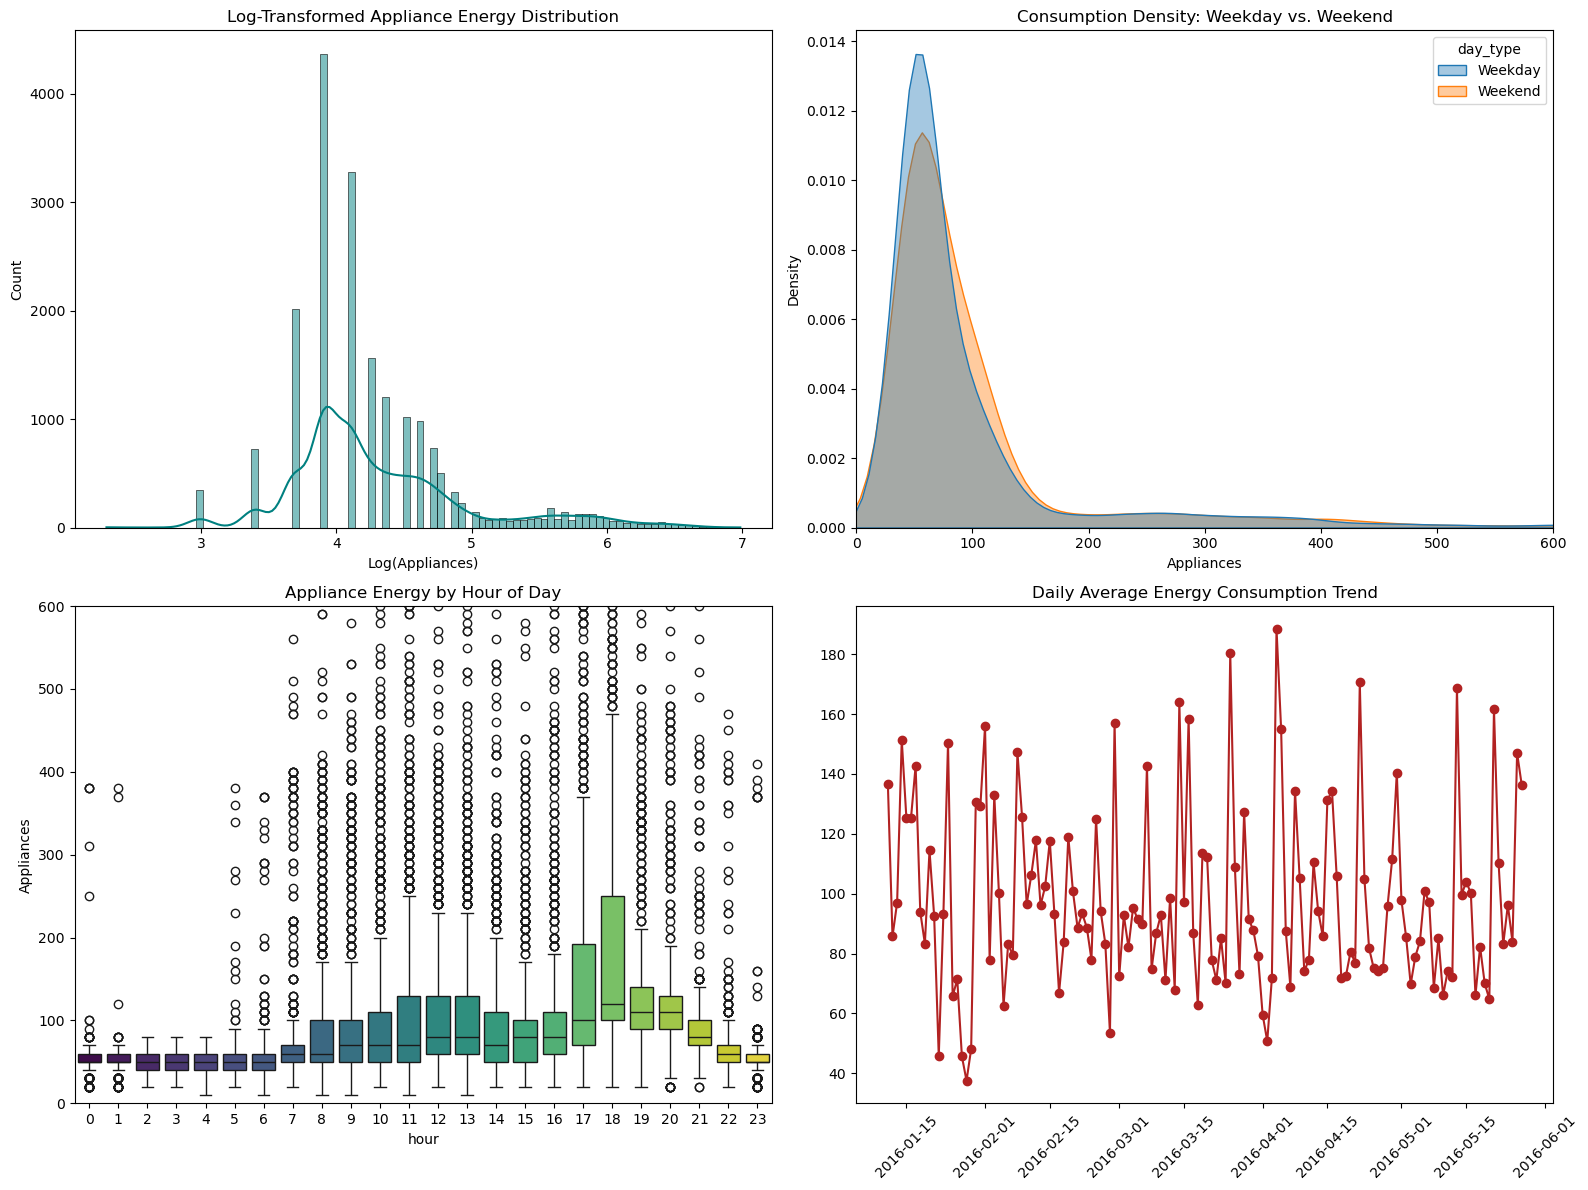

In [9]:
# Prepare Figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3)

# --- PLOT 1: Log-Transformed Distribution (Essential for Linear Models) ---
sns.histplot(energydata['log_Appliances'], kde=True, ax=axes[0, 0], color='teal')
axes[0, 0].set_title('Log-Transformed Appliance Energy Distribution', fontsize=12)
axes[0, 0].set_xlabel('Log(Appliances)')

# --- PLOT 2: Density by Day Type (Weekdays vs Weekends) ---
sns.kdeplot(data=energydata, x='Appliances', hue='day_type', fill=True, 
            common_norm=False, alpha=0.4, ax=axes[0, 1])
axes[0, 1].set_title('Consumption Density: Weekday vs. Weekend', fontsize=12)
axes[0, 1].set_xlim(0, 600) # Limiting x-axis to see the main distribution clearly

# --- PLOT 3: Hourly Boxplot (The "Behavioral" Predictor) ---
sns.boxplot(x='hour', y='Appliances', data=energydata, ax=axes[1, 0], 
            hue='hour', palette='viridis', legend=False) # Added hue and legend=False
axes[1, 0].set_title('Appliance Energy by Hour of Day', fontsize=12)
axes[1, 0].set_ylim(0, 600)

# --- PLOT 4: Daily Average Trend (The Time-Series View) ---
daily_avg = energydata.groupby('day')['Appliances'].mean()
axes[1, 1].plot(daily_avg.index, daily_avg.values, marker='o', linestyle='-', color='firebrick')
axes[1, 1].set_title('Daily Average Energy Consumption Trend', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

`Rationale for EDA Model Selection`

`I selected this set of EDA visualizations to ensure our modeling decisions are grounded in statistical validity and interpretability. First, I did a log-transformed histogram of Appliances because the raw consumption data is right-skewed, which violates normality assumptions required for linear regression. (something we learned from this week's topic) Applying the log transformation allows us to visually confirm improved symmetry and assess whether linear modeling assumptions are more reasonable.`

`Second, I retained Carlo’s density plot comparing weekday vs. weekend consumption because it provides a clear probabilistic comparison of behavioral differences across day types. Rather than simply comparing means, the KDE visualization shows the full distribution, highlighting differences in spread, peak concentration, and tail behavior. This directly supports feature engineering decisions such as including day-type indicators in the model.`

`Third, the hourly boxplot captures intra-day variability and reveals strong time-of-day effects in energy consumption. The clear shifts in median and dispersion across hours suggest that “hour” functions as a behavioral predictor and justifies its inclusion as a temporal feature.`

`Finally, the daily average time-series plot provides a macro-level temporal trend, allowing us to visually inspect seasonality, drift, and volatility over time. This supports evaluating whether temporal aggregation improves model stability and whether autocorrelation should be considered in future modeling iterations.`

`All plots were organized side-by-side to enhance interpretability, maintain narrative flow in the notebook, and visually connect distributional assumptions with temporal dynamics and segmentation insights. Together, these visualizations directly inform feature selection and validate the appropriateness of regression-based modeling for the energy efficiency objective.`

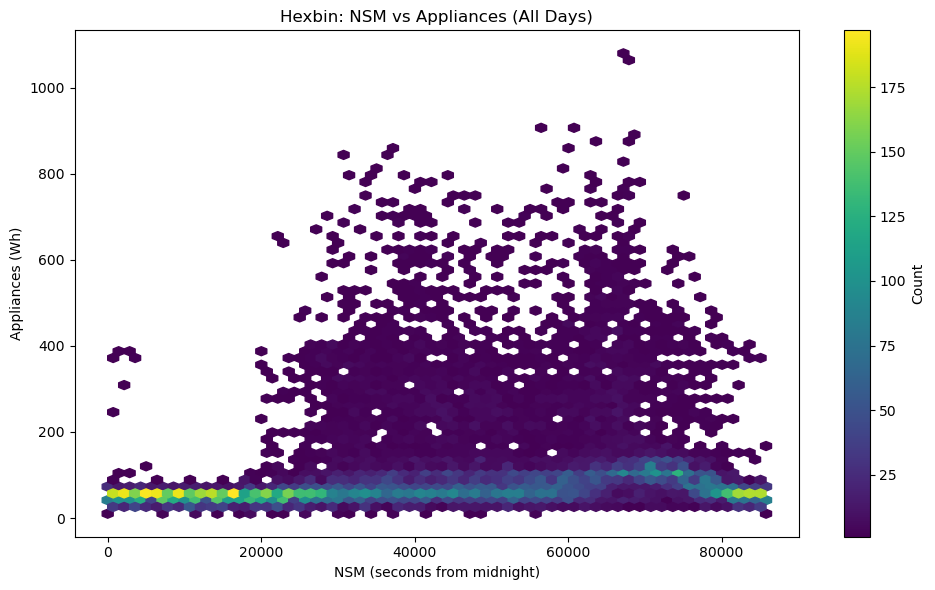

In [10]:
plt.figure(figsize=(10, 6))
plt.hexbin(
    energydata['NSM'],
    energydata['Appliances'],
    gridsize=60,
    cmap='viridis',
    mincnt=1
)
plt.colorbar(label='Count')
plt.title('Hexbin: NSM vs Appliances (All Days)')
plt.xlabel('NSM (seconds from midnight)')
plt.ylabel('Appliances (Wh)')
plt.tight_layout()
plt.show()




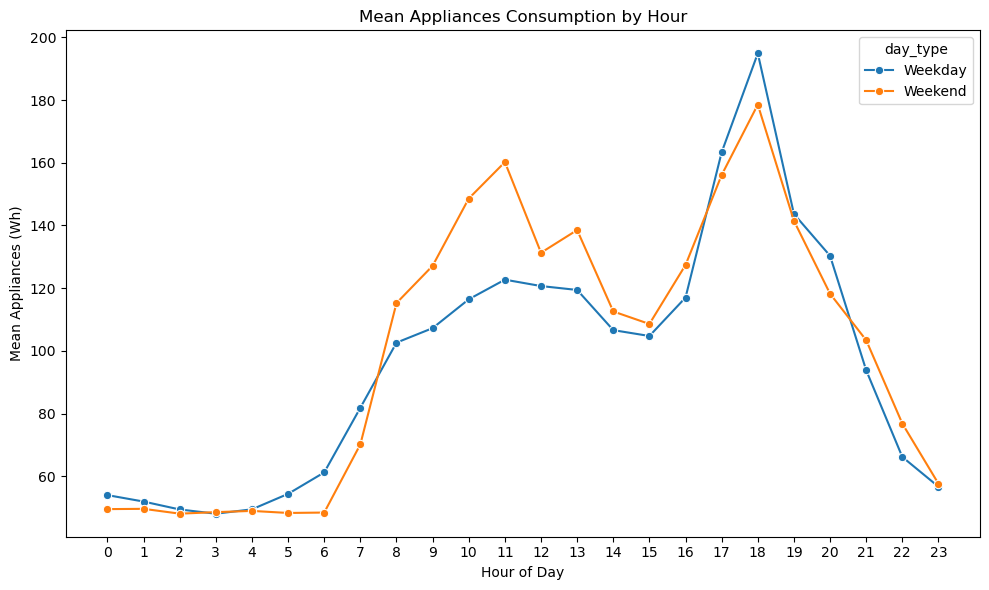

In [11]:
#Time of day Appliance consumption per hour
mean_by_hour = (
    energydata.groupby(['hour', 'day_type'])['Appliances']
      .mean()
      .reset_index()
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=mean_by_hour,
    x='hour',
    y='Appliances',
    hue='day_type',
    marker='o'
)
plt.title('Mean Appliances Consumption by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Appliances (Wh)')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()



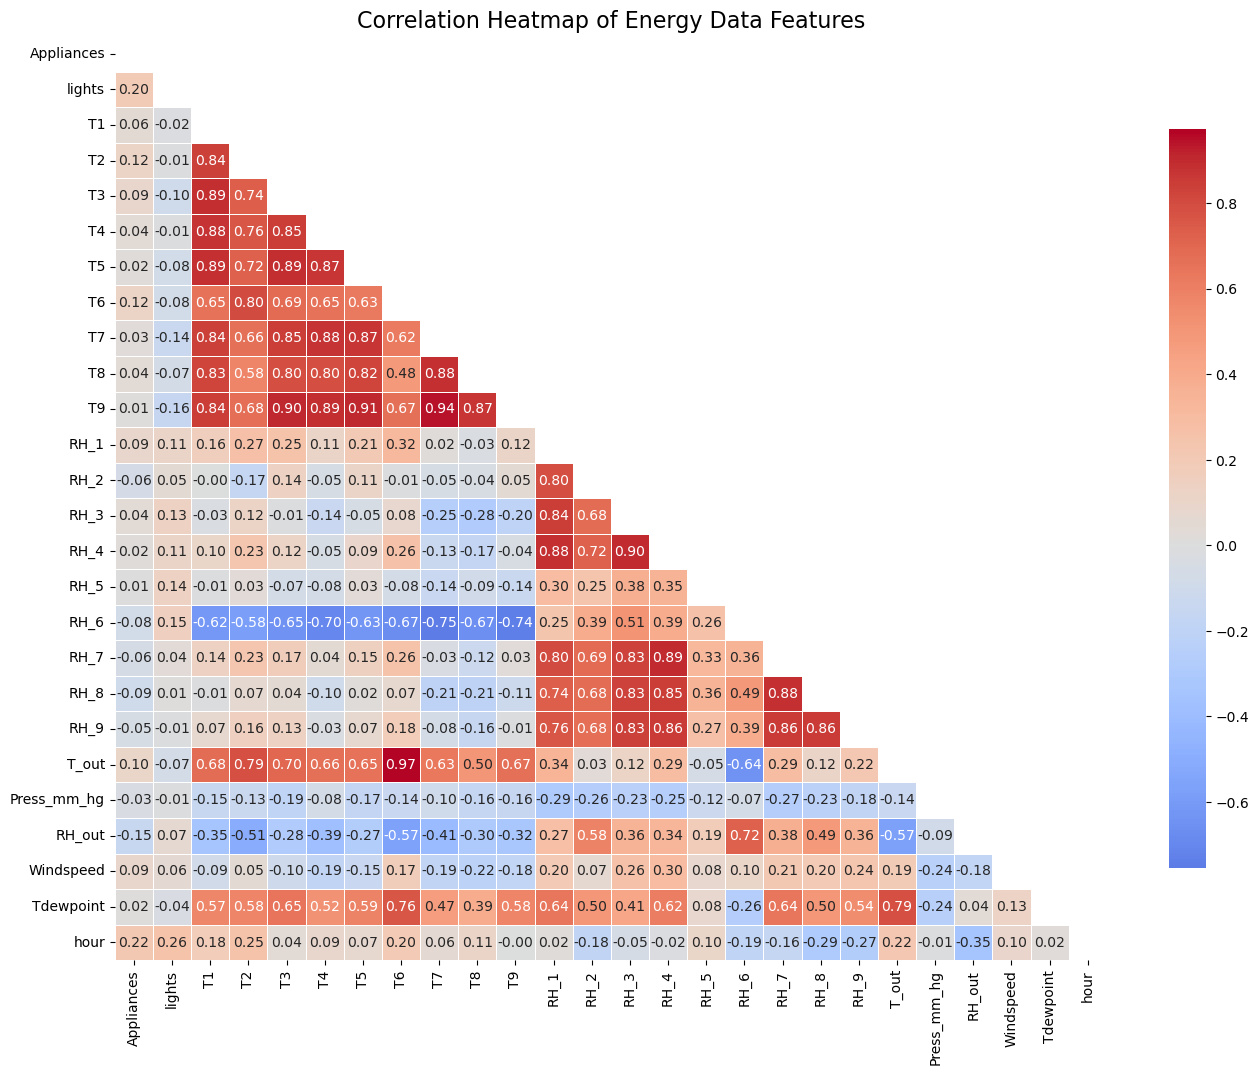

In [12]:
# 1. Select the columns for the correlation matrix
# We exclude 'rv1', 'rv2' as they are random noise and 'NSM' as it correlates with 'hour'
cols_to_corr = [
    'Appliances', 'lights', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
    'RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9',
    'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Tdewpoint', 'hour'
]

corr_matrix = energydata[cols_to_corr].corr()

# 2. Setup the figure
plt.figure(figsize=(16, 12))

# 3. Create a mask to hide the upper triangle (it's a mirror of the bottom)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 4. Plot Heatmap
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            center=0, linewidths=.5, cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap of Energy Data Features', fontsize=16)
plt.show()

`I added the correlation heatmap so we can clearly see how all predictors relate to each other and to Appliances before locking in our model. Based on the heatmap, several temperature sensors (T1–T9) are highly correlated with one another, which suggests multicollinearity could become an issue if we use standard multiple linear regression. We also see that individual predictors have relatively modest linear relationships with Appliances, meaning the signal is likely distributed across multiple correlated features rather than coming from a single dominant variable.`

  0%|          | 0/1000000 [00:00<?, ?it/s]

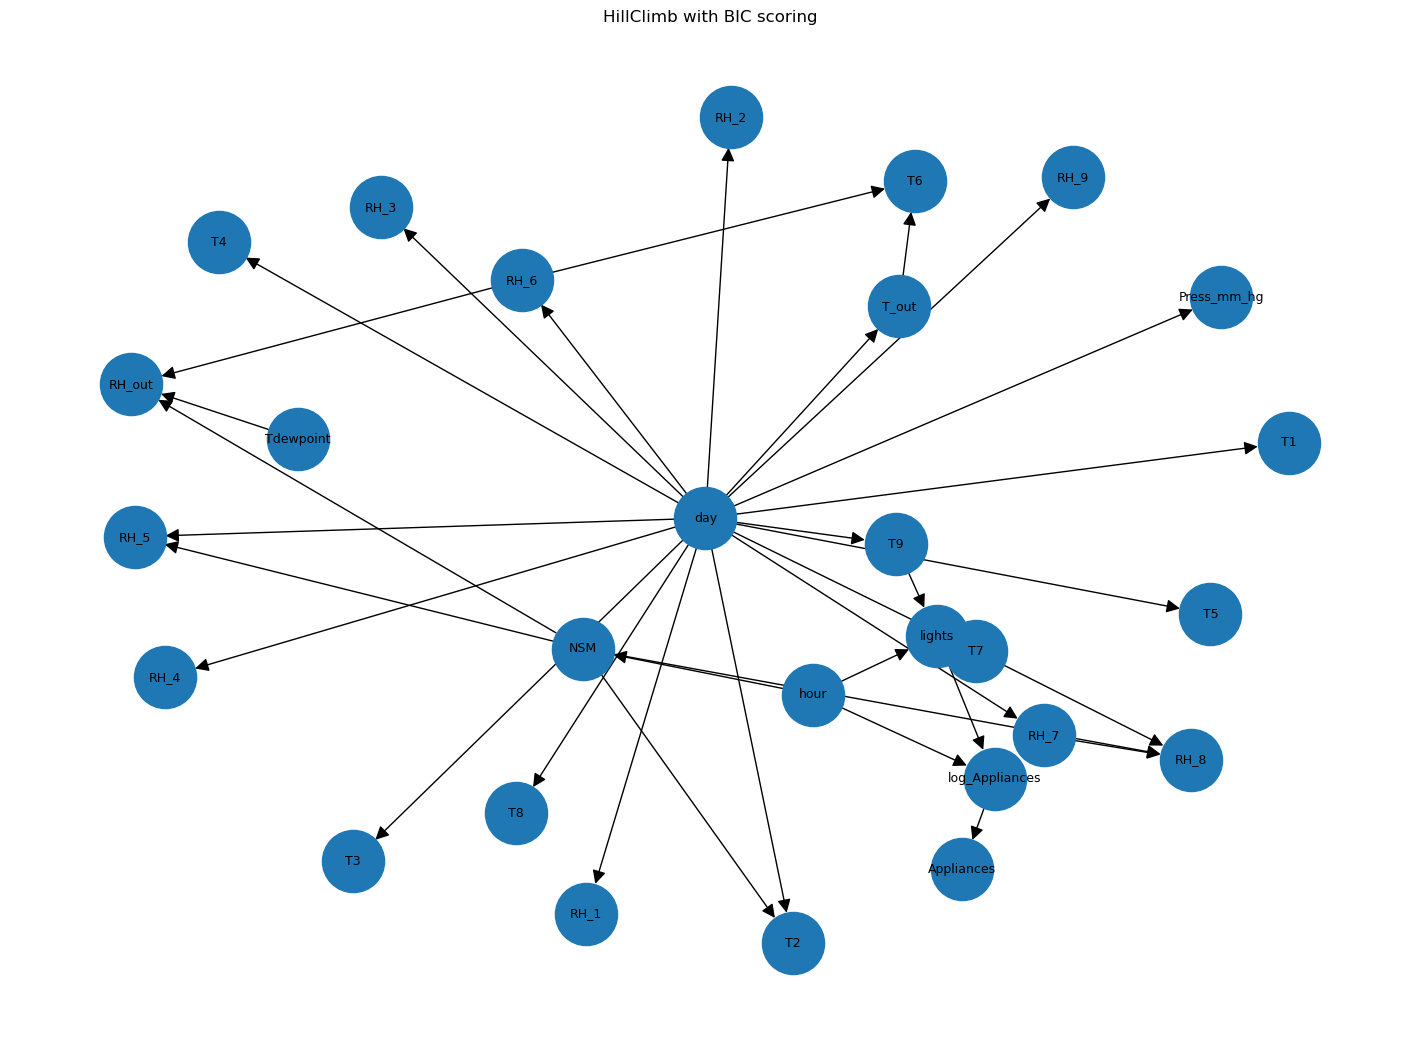

In [13]:

categorical_cols = [
    "date", "weekday", "is_weekend", "day_type", "hour", "day"
]

energydata = energydata.drop(columns=["rv1", "rv2"])

for col in categorical_cols:
    energydata[col] = energydata[col].astype("category")


continuous_cols = energydata.columns.difference(categorical_cols)


disc = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")
energydata[continuous_cols] = disc.fit_transform(energydata[continuous_cols])
energydata.head()

expert = ExpertKnowledge(
    forbidden_edges=[
        
        (c, 'Date') for c in energydata.columns if c != 'Date'       

    ] + [
        (c , 'weekday') for c in energydata.columns if c != 'weekday'         
        
    ] + [

        (c , 'is_weekend') for c in energydata.columns if c != 'is_weekend'
    ] + [

        (c , 'day_type') for c in energydata.columns if c != 'day_type'
    ] + [

        (c , 'hour') for c in energydata.columns if c != 'hour'
    ] + [

        (c , 'day') for c in energydata.columns if c != 'day'
    ] + [

        (c , 'Windspeed') for c in energydata.columns if c != 'Windspeed'
    ] + [

        (c , 'Tdewpoint') for c in energydata.columns if c != 'Tdewpoint'
    ] + [

        (c , 'Visibility') for c in energydata.columns if c != 'Visibility'
    ]
    
)


est = HillClimbSearch(energydata)
model = est.estimate(scoring_method=BIC(energydata), expert_knowledge=expert)


G = nx.DiGraph()
G.add_edges_from(model.edges())
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.3, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=9, arrowsize=20)
plt.title("HillClimb with BIC scoring")
plt.show()

In [14]:
model.edges()

OutEdgeView([('lights', 'log_Appliances'), ('RH_6', 'RH_out'), ('RH_6', 'T6'), ('T7', 'RH_8'), ('RH_7', 'RH_8'), ('T9', 'lights'), ('T_out', 'T6'), ('Tdewpoint', 'RH_out'), ('hour', 'NSM'), ('hour', 'log_Appliances'), ('hour', 'lights'), ('NSM', 'RH_out'), ('NSM', 'RH_8'), ('NSM', 'RH_5'), ('NSM', 'T2'), ('log_Appliances', 'Appliances'), ('day', 'T9'), ('day', 'T7'), ('day', 'Press_mm_hg'), ('day', 'T3'), ('day', 'T5'), ('day', 'RH_4'), ('day', 'T4'), ('day', 'RH_3'), ('day', 'RH_7'), ('day', 'T8'), ('day', 'RH_1'), ('day', 'RH_6'), ('day', 'T1'), ('day', 'T_out'), ('day', 'RH_9'), ('day', 'RH_2'), ('day', 'T2'), ('day', 'RH_5')])

#### Modeling

In [15]:
#Map time variables onto a circle to account for seasonality

df_model["date"] = pd.to_datetime(df_model["date"])

df_model["hour"] = df_model["date"].dt.hour
df_model["weekday_num"] = df_model["date"].dt.weekday
df_model["month"] = df_model["date"].dt.month

df_model["hour_sin"] = np.sin(2 * np.pi * df_model["hour"] / 24)
df_model["hour_cos"] = np.cos(2 * np.pi * df_model["hour"] / 24)

df_model["weekday_sin"] = np.sin(2 * np.pi * df_model["weekday_num"] / 7)
df_model["weekday_cos"] = np.cos(2 * np.pi * df_model["weekday_num"] / 7)

df_model["month_sin"] = np.sin(2 * np.pi * df_model["month"] / 12)
df_model["month_cos"] = np.cos(2 * np.pi * df_model["month"] / 12)


In [16]:
df_model = df_model.drop(columns=[
    "date", "weekday", "day_type", "is_weekend", "day", "rv1", "rv2","log_Appliances","hour"
])


In [17]:
df_model.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'NSM', 'weekday_num', 'month', 'hour_sin', 'hour_cos',
       'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [18]:
y = df_model["Appliances"]
X = df_model.drop(columns=["Appliances"])


In [19]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    median_absolute_error, 
    r2_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,shuffle=False
)

# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.01, max_iter=10000),
    "Ridge": Ridge(alpha=1.0, max_iter=10000),
    "Multiple Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    ),
    "GBM_model": GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        random_state=42
    ),
    "SVR-RBF": SVR(
        kernel="rbf",
        C=10,
        gamma="scale",
        epsilon=0.1
    ),
}

results = {}


for name, model in models.items():
  
    model_is_tree_based = isinstance(model, (RandomForestRegressor, GradientBoostingRegressor, XGBRegressor))
    
    if model_is_tree_based:
        pipe = Pipeline([("model", model)])
    else:
        pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    results[name] = {
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": mean_squared_error(y_test, preds),
        "R2": r2_score(y_test, preds),
        "ExplainedVariance": 1 - np.var(y_test - preds) / np.var(y_test),
        "Bias": np.mean(y_test - preds)
    }

results

{'Random Forest': {'MAE': 163.82401172382134,
  'RMSE': 41152.13574536281,
  'R2': -3.9652589909621323,
  'ExplainedVariance': -1.214883025582235,
  'Bias': np.float64(-150.9806422965074)},
 'Gradient Boosting': {'MAE': 187.12740166316016,
  'RMSE': 53274.21610135569,
  'R2': -5.427862751048667,
  'ExplainedVariance': -1.9620036060449402,
  'Bias': np.float64(-169.4847748815019)},
 'Linear Regression': {'MAE': 89.95491163768929,
  'RMSE': 14784.87246761652,
  'R2': -0.783886051608722,
  'ExplainedVariance': 0.13043541397632097,
  'Bias': np.float64(87.05118640617492)},
 'Lasso': {'MAE': 79.37364898766091,
  'RMSE': 12930.211319020216,
  'R2': -0.5601097450705212,
  'ExplainedVariance': 0.13384371064468692,
  'Bias': np.float64(75.83861757992436)},
 'Ridge': {'MAE': 76.5513608245226,
  'RMSE': 12466.046406650927,
  'R2': -0.5041053855716231,
  'ExplainedVariance': 0.13413703371945007,
  'Bias': np.float64(72.7307505103447)},
 'Multiple Linear Regression': {'MAE': 89.95491163768929,
  'R